                     precision    recall  f1-score   support

Insufficient_Weight       0.86      0.93      0.90       524
      Normal_Weight       0.69      0.62      0.65       626
     Obesity_Type_I       0.64      0.72      0.68       543
    Obesity_Type_II       0.91      0.97      0.94       657
   Obesity_Type_III       0.99      1.00      0.99       804
 Overweight_Level_I       0.54      0.53      0.54       484
Overweight_Level_II       0.56      0.47      0.51       514

           accuracy                           0.77      4152
          macro avg       0.74      0.75      0.74      4152
       weighted avg       0.76      0.77      0.77      4152



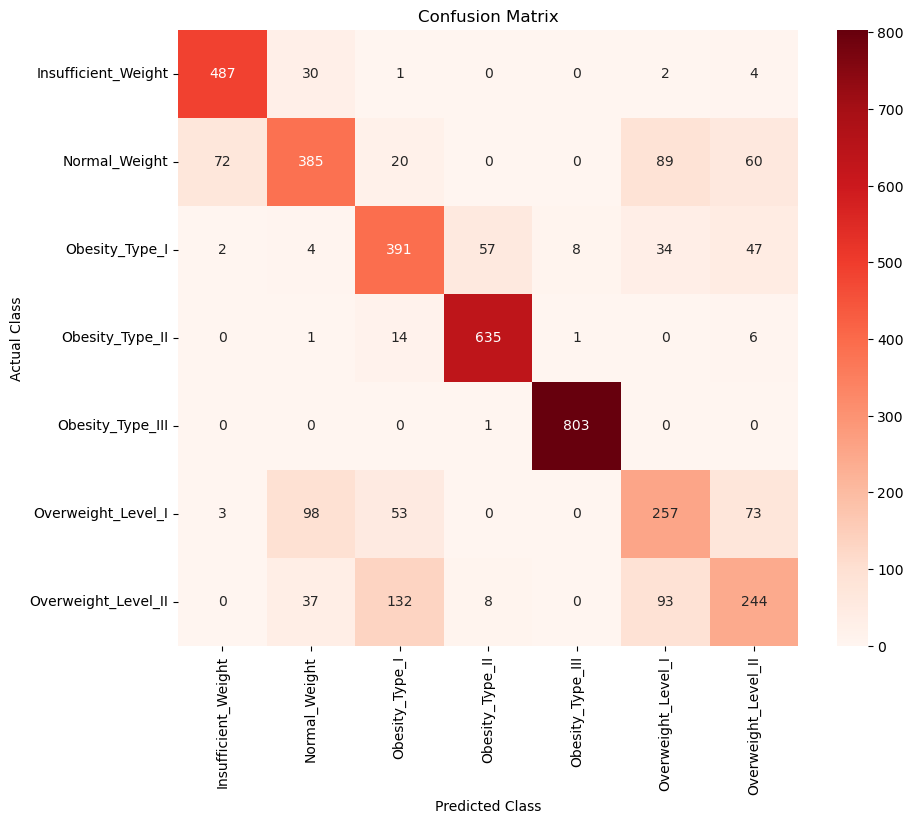

In [34]:
# Бейзлайн лог.регресс
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('train_obesity.csv', usecols=lambda column: column != 'id')

# Разделение на признаки и целевую переменную
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определение категориальных и числовых признаков
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Пайплайны предобработки
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# `ColumnTransformer`
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Пайплайн модели
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'))
])

# Обучение модели
pipeline.fit(X_train, y_train)

# Прогнозирование на тестовых данных
y_pred = pipeline.predict(X_test)

# Оценка модели
report = classification_report(y_test, y_pred)
print(report)

# Conf. matrix 
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=pipeline.classes_, columns=pipeline.classes_)

# Визуализация матрицы ошибок
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Загрузка данных, исключая столбец 'id'
df = pd.read_csv('train_obesity.csv', usecols=lambda column: column != 'id')

X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

# Разделение на выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определение кат и числ признаков
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Пайплайны предобработки
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Пайплайн 
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Параметры для RandomizedSearchCV
param_dist = {
    'classifier__n_estimators': np.arange(100, 1000, 100),
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__max_depth': np.arange(5, 20, 5),
    'classifier__min_samples_split': np.arange(2, 11, 2),
    'classifier__min_samples_leaf': np.arange(1, 6, 1),
    'classifier__criterion': ['gini', 'entropy']
}

# RandomizedSearchCV 
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=10,  
    cv=3,      
    random_state=42,
    n_jobs=-1,  
    verbose=1
)

# Обучение модели с подбором параметров
random_search.fit(X_train, y_train)

# Лучшая модель
best_pipeline = random_search.best_estimator_

# Прогнозирование на тестовых данных
y_pred = best_pipeline.predict(X_test)

# Оценка модели
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=best_pipeline.classes_, columns=best_pipeline.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()


TypeError: LabelEncoder() takes no arguments